%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(4.8, 2.7)

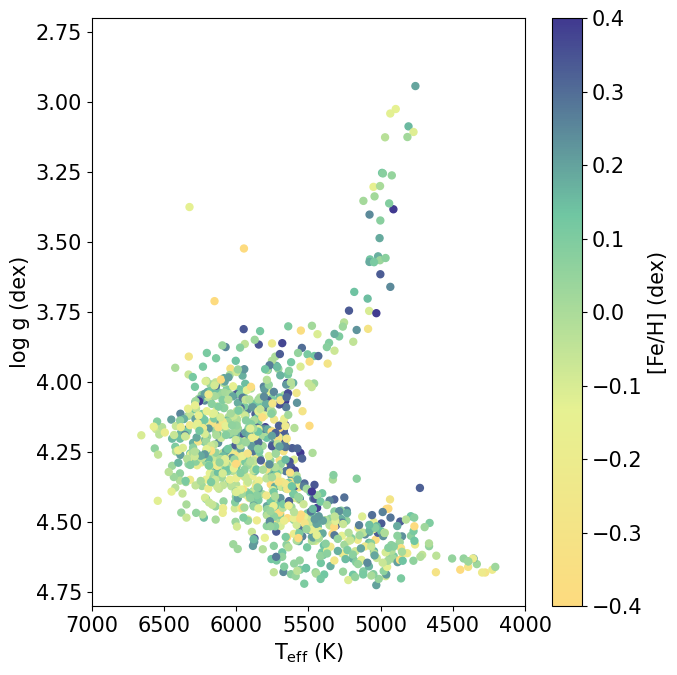

In [1]:
# HR diagram
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap_colors= ['#403990', '#70C6A2', '#E6F192', '#FDDB7F']

cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors[::-1])
#cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

%pylab inline
training_labels = pd.read_csv('./data/label_dataframes/training_labels.csv')

figure(figsize=(7,7))
rcParams['font.size']=15
scatter(training_labels.cks_teff, training_labels.cks_logg,
       c=training_labels.cks_feh, s=25, cmap=cmap, vmin=-0.4,vmax=0.4)
colorbar(label='[Fe/H] (dex)')
xlabel(r'T$_{\rm eff}$ (K)')
ylabel('log g (dex)')
tight_layout()
xlim(7000,4000);ylim(4.8,2.7)

Text(0, 0.5, 'number of stars')

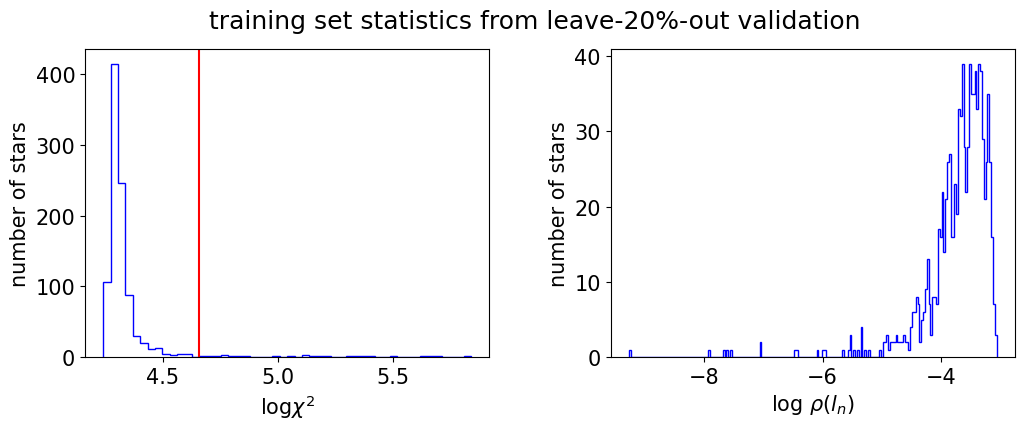

In [2]:
# next: one-to-one plots from leave-one-out validatoin colored by training density
# and chisq
model_path='./data/cannon_models/rchip/orders_2.12_omitted_dwt/'
training_metrics = pd.read_csv(model_path+'cannon_labels.csv')
figure(figsize=(12,4));suptitle('training set statistics from leave-20%-out validation')
subplots_adjust(wspace=0.3)
subplot(121)
hist(np.log10(training_metrics.fit_chisq), bins=50, histtype='step', color='b')
xlabel(r'log$\chi^2$');ylabel('number of stars')

# overplot the number of pixels
import thecannon as tc
cannon_model = tc.CannonModel.read('./data/cannon_models/rchip/orders_2.12_omitted_dwt/cannon_model.model')
n_pixels = len(cannon_model(cannon_model._fiducials))
axvline(np.log10(n_pixels), color='r')

subplot(122)
hist(np.log10(training_metrics.training_density), bins=200, histtype='step', color='b')
xlabel(r'log $\rho$($l_n$)');ylabel('number of stars')

(0.0, 40.0)

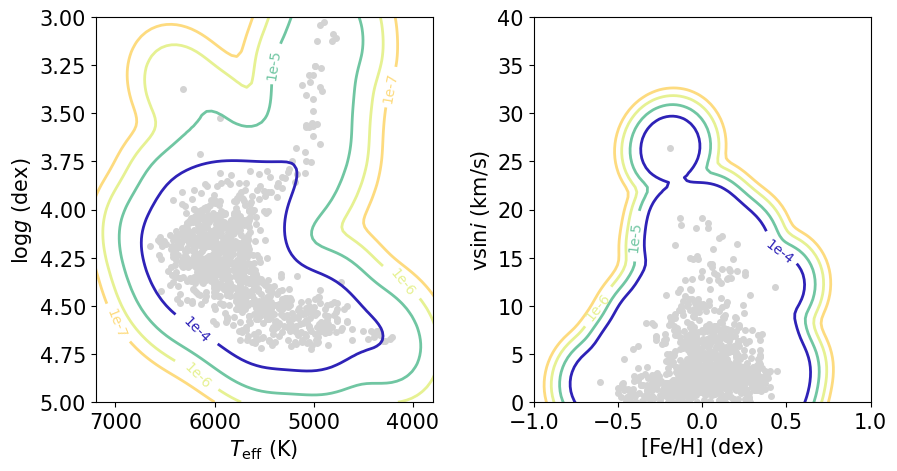

In [4]:
from scipy import stats

model=cannon_model
training_data = model.training_set_labels
training_density_kde = stats.gaussian_kde(training_data.T)
def training_density(param):
    density = training_density_kde(param)[0]
    return density

from matplotlib import cm, ticker

bounds = {'cks_teff':(3000,8000),
         'cks_logg':(3,5.0),
         'cks_feh':(-1,1),
         'cks_vsini':(-10,40)}

axis_labels = {'cks_teff':r'$T_{\rm eff}$ (K)',
         'cks_logg':r'log$g$ (dex)',
         'cks_feh':'[Fe/H] (dex)',
         'cks_vsini':r'vsin$i$ (km/s)'}

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap_colors= ['#2E22B7', '#70C6A2', '#E6F192', '#FDDB7F']
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors[::-1])
training_label_names = ['cks_teff', 'cks_logg','cks_feh', 'cks_vsini']
training_label_df = training_labels

def plot_kde(x, y, ax):
    retained_dim = (training_label_names.index(x), training_label_names.index(y))
    marginal_kde = training_density_kde.marginal(retained_dim) 

    xmin, xmax = bounds[x]
    ymin, ymax = bounds[y]

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(marginal_kde(positions).T, X.shape)
    
    clevels = np.arange(-7,-3,1)
    strs = ['1e-7', '1e-6', '1e-5', '1e-4']
    
    ax.plot(training_label_df[x], training_label_df[y],'o', color='lightgrey', ms=4)
    contour_plot = ax.contour(np.log10(Z).T,extent=[xmin, xmax, ymin, ymax], 
                           cmap=cmap, levels=clevels,
                             vmin=-7,vmax=-4, linewidths = 2*np.ones(len(clevels)))
    ax.set_xlim([xmin, xmax]);ax.set_ylim([ymin, ymax])

    fmt = {}
    for l, s in zip(contour_plot.levels, strs):
        fmt[l] = s
    ax.clabel(contour_plot, contour_plot.levels[::1], inline=True, fontsize=10, fmt=fmt)
    ax.set_xlabel(axis_labels[x])
    ax.set_ylabel(axis_labels[y])

rcParams['font.size']=15
fig, axes = plt.subplots(1,2, figsize=(10,5))
subplots_adjust(wspace=0.3)

plot_kde('cks_teff', 'cks_logg', axes[0])
axes[0].set_xlim(7200,3800);axes[0].set_ylim(5,3)
plot_kde('cks_feh', 'cks_vsini', axes[1])
axes[1].set_ylim(0,40)



# now I need to make sure it doesn't look bimodal
# but I should note that I don't have a training density cutoff for this model

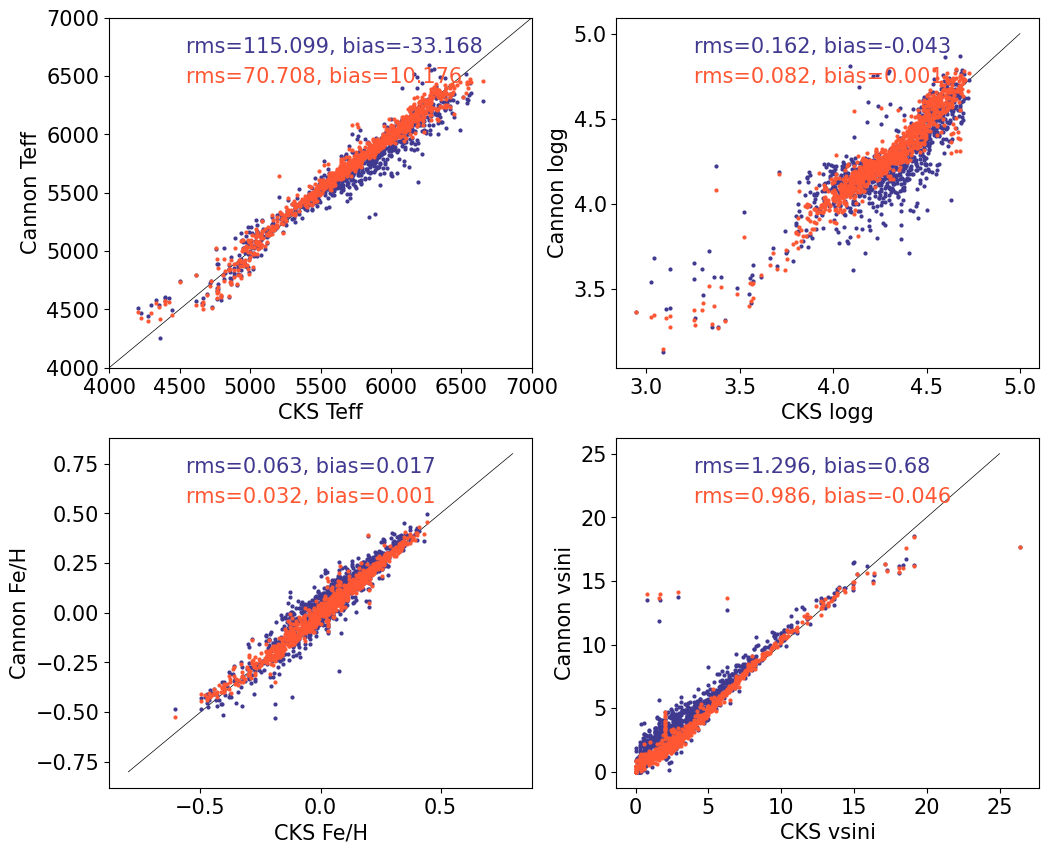

In [8]:
# okay now I need to re-run all this code...
# but I think everything in this cell will be easier,


# function to create one-to-one plot
def plot_one2one(label_df, axes, c='b'):
    
    keys = ['cks_teff', 'cks_logg','cks_feh','cks_vsini',
       'cannon_teff', 'cannon_logg','cannon_feh','cannon_vsini']
    
    def stats_str(x,y):
        diff = y - x
        rms = np.round(np.sqrt(np.sum(diff**2)/len(diff)), 3)
        bias = np.round(np.mean(diff), 3)
        return 'rms={}, bias={}'.format(rms, bias)
    
    def plotxy(x,y,ax):
        ax.plot(x,y,'.',color=c, ms=4)
        ax.plot(x[0],y[0],alpha=0,label=stats_str(x,y), color=c, ms=0.5)
        ax.legend(labelcolor='linecolor', frameon=False,fontsize=15, loc='upper left')
    
    # plot the labels in their panels.
    plotxy(label_df.cks_teff, label_df.cannon_teff, axes[0,0])
    plotxy(label_df.cks_logg, label_df.cannon_logg, axes[0,1])
    plotxy(label_df.cks_feh, label_df.cannon_feh, axes[1,0])
    plotxy(label_df.cks_vsini, label_df.cannon_vsini, axes[1,1])
    
fig, axes = plt.subplots(2,2, figsize=(12,10))
# plot one2one lines
axes[0,0].plot([4000,7000],[4000,7000], 'k-', lw=0.5)
axes[0,0].set_xlabel('CKS Teff');axes[0,0].set_ylabel('Cannon Teff')
axes[0,0].set_xlim(4000,7000);axes[0,0].set_ylim(4000,7000)

axes[0,1].plot([4,5],[4,5], 'k-', lw=0.5)
axes[0,1].set_xlabel('CKS logg');axes[0,1].set_ylabel('Cannon logg')

axes[1,0].plot([-0.8,0.8],[-0.8,0.8], 'k-', lw=0.5)
axes[1,0].set_xlabel('CKS Fe/H');axes[1,0].set_ylabel('Cannon Fe/H')

axes[1,1].plot([0,25],[0,25], 'k-', lw=0.5)
axes[1,1].set_xlabel('CKS vsini');axes[1,1].set_ylabel('Cannon vsini')

dwt_labels = pd.read_csv(model_path+'cannon_labels.csv')
original_labels = pd.read_csv('./data/cannon_models/rchip/orders_2.12_omitted_original/cannon_labels.csv')
plot_one2one(original_labels, axes, c='#403990')
plot_one2one(dwt_labels, axes, c='#FF5733')

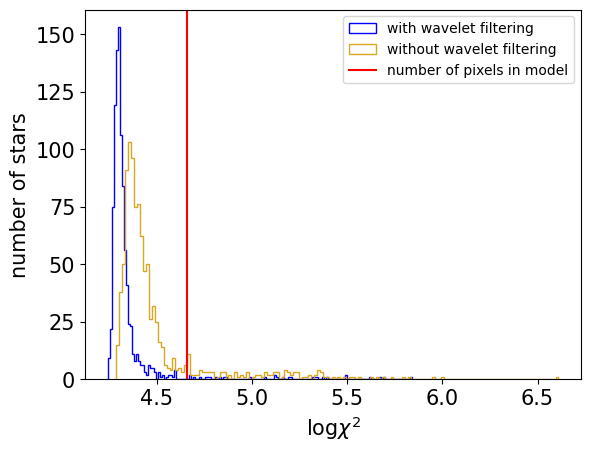

In [10]:
# new chi-squared distribution
# still peaks below, which makes me think that the CKS errors are over-estimated?
# and I don't think it's because of the error propagation because it happens for 
# the model without wavelet filtering
# I think the only reason it's less true is because the model with wavelet filtering
# finds better fits.
hist(np.log10(training_metrics.fit_chisq), histtype='step', 
     color='b', bins=150, label='with wavelet filtering')

original_training_metrics = original_labels
hist(np.log10(original_training_metrics.fit_chisq), histtype='step', 
     color='goldenrod', bins=150, label='without wavelet filtering')

xlabel(r'log$\chi^2$');ylabel('number of stars')
axvline(np.log10(len(model(model._fiducials))), color='r', label='number of pixels in model')
legend(fontsize=10)

In [11]:
# what if I take into account the masked pixels?
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

max_v_shift = 30*u.km/u.s 
telluric_wmin = (6270*u.angstrom*(1-max_v_shift/c.c)).value
telluric_wmax = (6310*u.angstrom*(1+max_v_shift/c.c)).value


reference_w_filename = './data/cannon_training_data/cannon_reference_w.fits'
w_data = fits.open(reference_w_filename)[0].data
order_numbers = [i for i in range(1,17) if i not in (11,12)]
w = w_data[[i-1 for i in order_numbers]].flatten()
len(np.where((w>telluric_wmin) & (w<telluric_wmax))[0])

1320

Text(-0.1, 1, 'K02864')

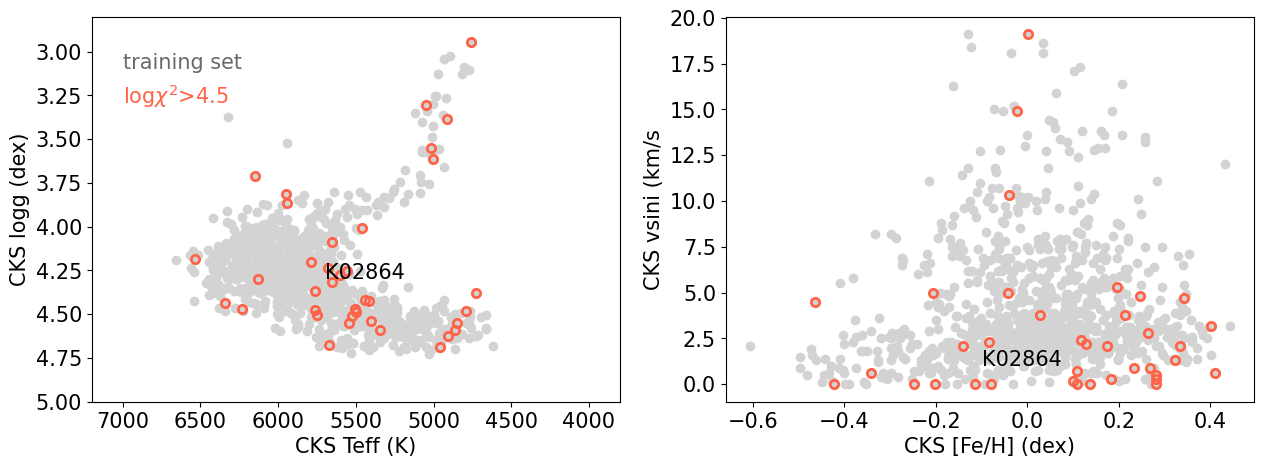

In [6]:
large_chisq_sample = training_metrics.query('chisq>10**(4.5)')

training_labels = model.training_set_labels.T
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(training_labels[0], training_labels[1], 'o', color='lightgrey')
axes[0].plot(large_chisq_sample.cks_steff, large_chisq_sample.cks_slogg, 'o', 
       markerfacecolor="None",markeredgecolor='tomato', markeredgewidth=2)
axes[0].set_xlabel('CKS Teff (K)');axes[0].set_ylabel('CKS logg (dex)')
axes[0].text(7000,3.1,'training set',color='dimgrey')
axes[0].text(7000,3.3,r'log$\chi^2$>4.5',color='tomato')
axes[0].text(5700,4.3, 'K02864')
axes[0].set_xlim(7200,3800);axes[0].set_ylim(5,2.8)


axes[1].plot(training_labels[2], training_labels[3], 'o', color='lightgrey')
axes[1].plot(large_chisq_sample.cks_smet, large_chisq_sample.cks_svsini, 'o', 
       markerfacecolor="None",markeredgecolor='tomato', markeredgewidth=2)
axes[1].set_xlabel('CKS [Fe/H] (dex)');axes[1].set_ylabel('CKS vsini (km/s')
axes[1].text(-0.1,1, 'K02864')

In [7]:
training_flux_df = pd.read_csv('./data/cannon_training_data/training_flux_orders_11-12_omitted_dwt.csv')
training_sigma_df = pd.read_csv('./data/cannon_training_data/training_sigma_orders_11-12_omitted_dwt.csv')
import thecannon as tc
import spectrum
model = tc.CannonModel.read('./data/cannon_models/rchip_orders_11-12_omitted_dwt/rchip_orders_11-12_omitted_dwt.model')

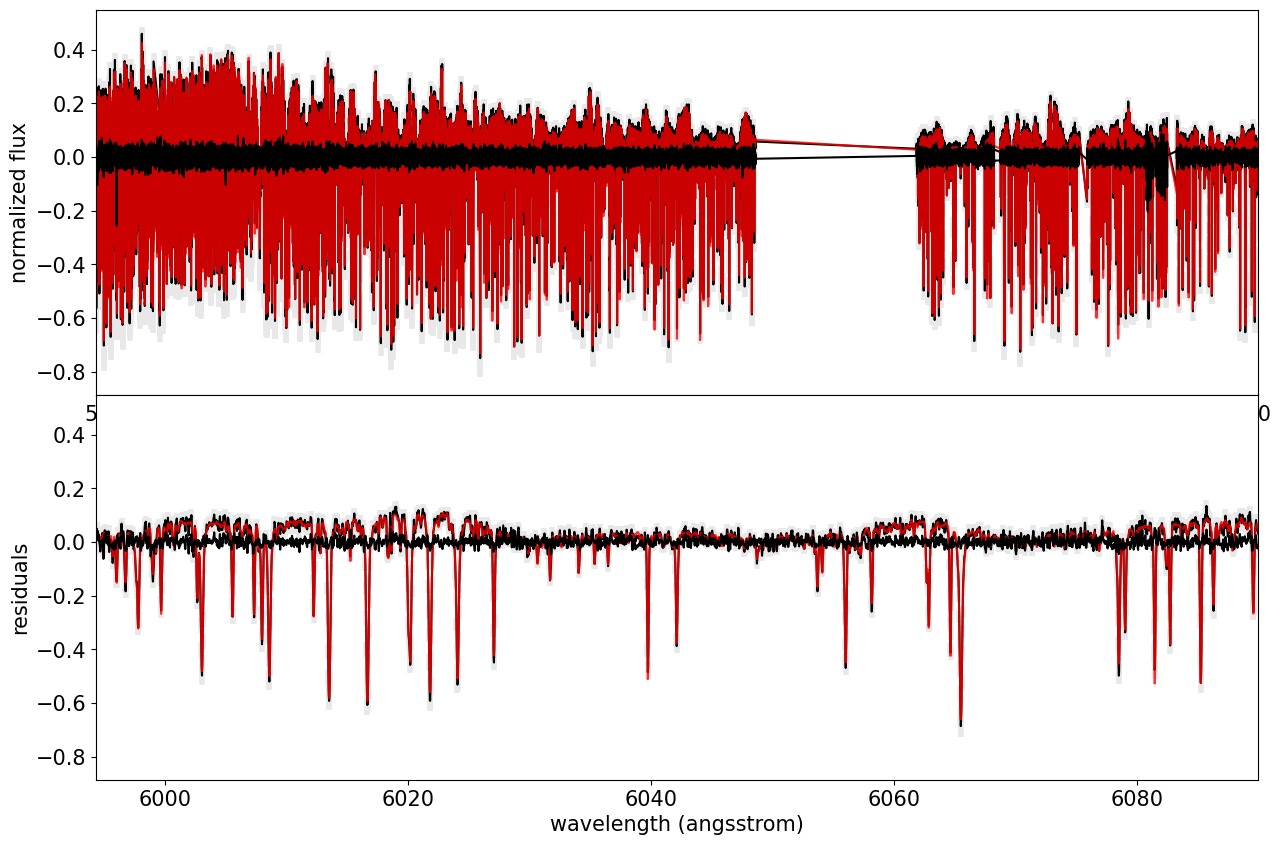

In [8]:
spectrum.Spectrum(
            training_flux_df['K00003'], 
            training_sigma_df['K00003'], 
            [i for i in range(1,17) if i not in (11,12)], 
            model).plot_fit(13)

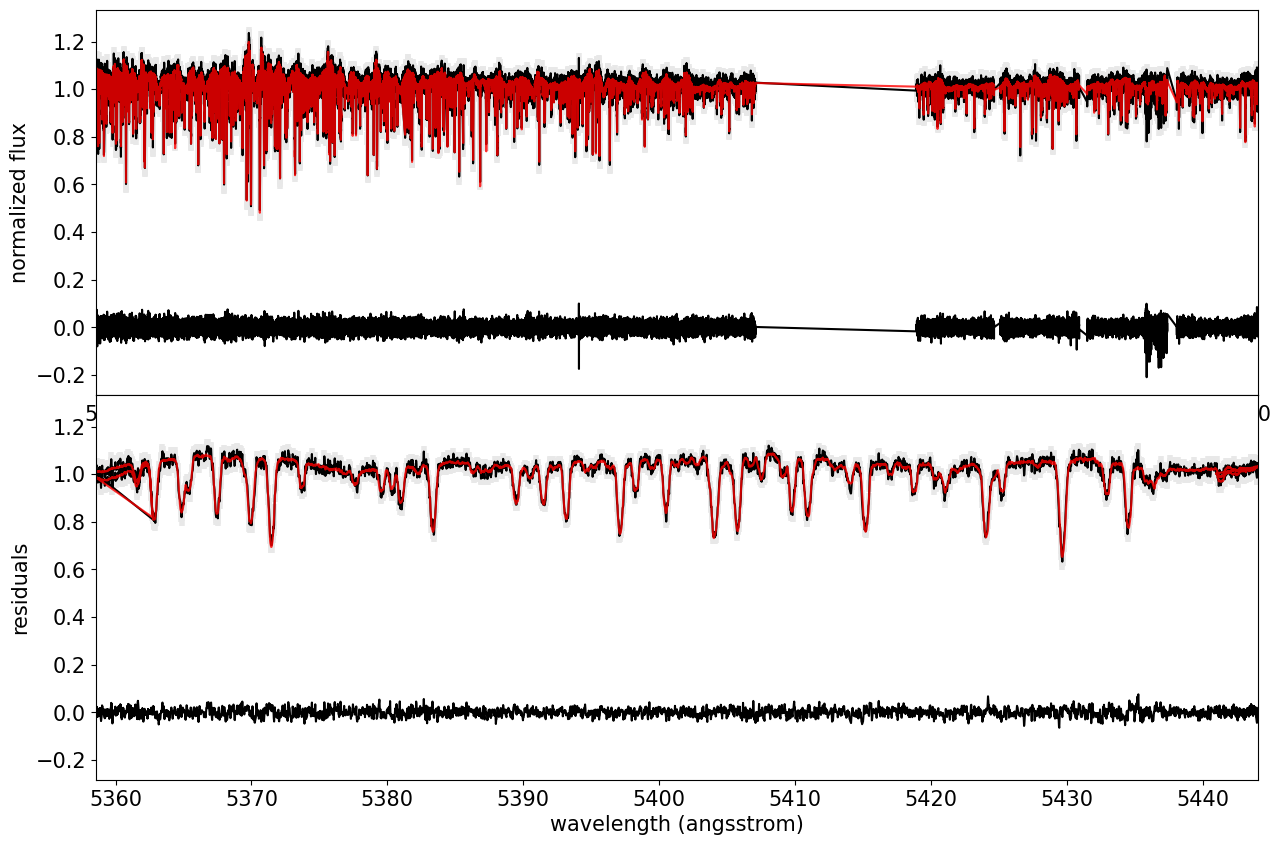

In [33]:
spectrum.Spectrum(
            training_flux_df['K01888'], 
            training_sigma_df['K01888'], 
            [i for i in range(1,17) if i not in (11,12)],  
            model).plot_fit(6)